## Reinforcement Learning in Practice

This notebook shows:
1) How to generate a simple RL "dataset" (logged transitions) from an environment.
2) How to train two widely-used RL algorithms:
   - DQN (for discrete action spaces)
   - PPO (general-purpose, very popular)
3) How to evaluate and compare them.

Environment: CartPole-v1 (classic, simple, fast).
Dataset: transitions (s, a, r, s', done) saved to CSV.


## Imports

In [20]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor


## Create environment helpers

In [21]:
def make_env(env_id:str,seed:int = 42):
    """
    Creates a Gymnasium environment wrapped with Monitor for logging episode stats.
    """
    env = gym.make(env_id)
    env = Monitor(env)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    return env

ENV_ID = "CartPole-v1"
SEED = 42

## Generate simple transitions dataset

In [22]:
def collect_transitions_dataset(env_id: str, num_steps: int = 50_000, seed: int = 42):
    """
    Collects transitions (s, a, r, s_next, done) using a random policy.
    This is a simple RL dataset you can inspect and reuse.

    Returns:
      df (pd.DataFrame)
    """
    env = gym.make(env_id)
    obs, info = env.reset(seed=seed)
    env.action_space.seed(seed)

    rows = []
    steps = 0

    while steps < num_steps:
        # Random action (behavior policy)
        action = env.action_space.sample()

        next_obs, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)

        rows.append({
            "s0": float(obs[0]),
            "s1": float(obs[1]),
            "s2": float(obs[2]),
            "s3": float(obs[3]),
            "action": int(action),
            "reward": float(reward),
            "s0_next": float(next_obs[0]),
            "s1_next": float(next_obs[1]),
            "s2_next": float(next_obs[2]),
            "s3_next": float(next_obs[3]),
            "done": int(done),
        })

        obs = next_obs
        steps += 1

        if done:
            obs, info = env.reset()

    env.close()
    return pd.DataFrame(rows)


df = collect_transitions_dataset(ENV_ID, num_steps=50_000, seed=SEED)
df.head()


,s0,s1,s2,s3,action,reward,s0_next,s1_next,s2_next,s3_next,done
0,0.027396,-0.006112,0.035860,0.019737,0,1.0,0.027273,-0.201730,0.036255,0.323515,0
1,0.027273,-0.201730,0.036255,0.323515,1,1.0,0.023239,-0.007142,0.042725,0.042482,0
2,0.023239,-0.007142,0.042725,0.042482,1,1.0,0.023096,0.187342,0.043574,-0.236421,0
3,0.023096,0.187342,0.043574,-0.236421,0,1.0,0.026843,-0.008375,0.038846,0.069682,0
4,0.026843,-0.008375,0.038846,0.069682,0,1.0,0.026675,-0.204031,0.040240,0.374364,0


## Saving the dataset and simple analysis

In [23]:
DATA_PATH = "cartpole_transitions.csv"
df.to_csv(DATA_PATH, index=False)

print("Saved dataset to:", os.path.abspath(DATA_PATH))
print("Shape:", df.shape)

print("\nBasic stats:")
print(df[["action", "reward", "done"]].describe())

print("\nDone rate:", df["done"].mean())
print("Action distribution:\n", df["action"].value_counts(normalize=True))


Saved dataset to: C:\GitHub\data-science\machine-learning\reinforcement-learning\cartpole_transitions.csv
Shape: (50000, 11)

Basic stats:
             action   reward          done
count  50000.000000  50000.0  50000.000000
mean       0.500580      1.0      0.044960
std        0.500005      0.0      0.207218
min        0.000000      1.0      0.000000
25%        0.000000      1.0      0.000000
50%        1.000000      1.0      0.000000
75%        1.000000      1.0      0.000000
max        1.000000      1.0      1.000000

Done rate: 0.04496
Action distribution:
 action
1    0.50058
0    0.49942
Name: proportion, dtype: float64


## Visualize reward ditribution and some features

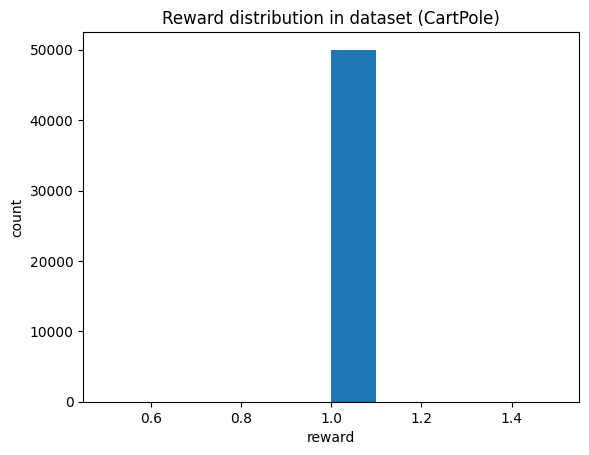

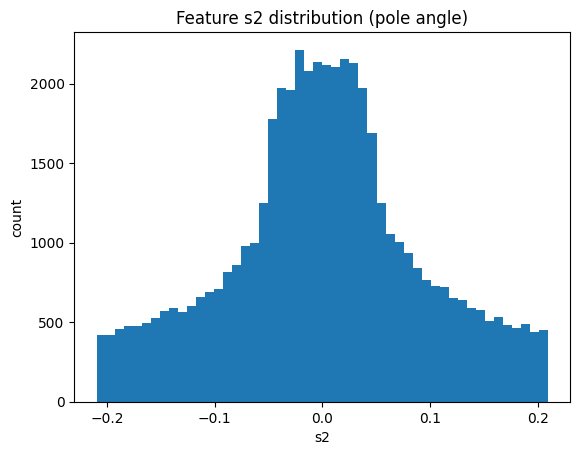

In [24]:
plt.figure()
plt.hist(df["reward"].values, bins=10)
plt.title("Reward distribution in dataset (CartPole)")
plt.xlabel("reward")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(df["s2"].values, bins=50)
plt.title("Feature s2 distribution (pole angle)")
plt.xlabel("s2")
plt.ylabel("count")
plt.show()


## What DQN is doing (idea + steps)

**DQN (Deep Q-Network)** is a way to learn the best action to take in each state when actions are **discrete** (like left/right).
It learns a function **Q(s, a)** = “how good is it to take action *a* in state *s* (total future reward).”

Because states can be continuous/large, DQN uses a **neural network** instead of a Q-table:

- Input: state `s`
- Output: a Q-value for each action (e.g., `[Q(s,left), Q(s,right)]`)

### The goal (Bellman idea)
DQN tries to make its Q-values satisfy the Bellman optimality equation:

**Target:**
y = r + γ * max_a' Q_target(s', a')

Meaning:
- get immediate reward `r`
- plus discounted best possible value from the next state `s'`

If the episode ended (`done=True`), the target is just:
y = r

### The training loop (high level)
1) **Interact with the environment**:
   - from current state `s`, choose action using **ε-greedy**:
     - with probability ε: random action (explore)
     - otherwise: best action from the network (exploit)
   - environment returns `(s', r, done)`

2) **Store experience** in a replay buffer:
   - save transition `(s, a, r, s', done)`
   - this buffer becomes your “dataset” of past experience

3) **Sample a random mini-batch** from the buffer:
   - random batches break correlation and stabilize training

4) **Compute Bellman targets** for the batch:
   - y_i = r_i + γ * max_a' Q_target(s'_i, a')  (or y_i = r_i if done)

5) **Update the neural network**:
   - predict Q_online(s_i, a_i)
   - minimize loss: (y_i - Q_online(s_i, a_i))²
   - do gradient descent

6) **Stabilize with a target network**:
   - keep a second network `Q_target` that changes slowly
   - either copy weights every N steps (hard update),
     or do soft updates (small blending)
   - this prevents “moving target” instability

### Why DQN works
- Replay buffer = stable training data + reuse experience
- Target network = stable learning targets
- Neural net = generalizes across similar states (handles continuous/large state spaces)

In short: **DQN learns Q(s,a) with a neural net by repeatedly fitting Bellman targets from replayed experience.**


In [25]:
train_env = make_env(ENV_ID, seed=SEED)
eval_env = make_env(ENV_ID, seed=SEED + 1)

# DQN is a go-to algorithm for discrete action spaces
dqn_model = DQN(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=1e-3,
    buffer_size=50_000,     # replay buffer capacity
    learning_starts=1_000,  # start learning after some experience collected
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1_000,
    exploration_fraction=0.2,
    exploration_final_eps=0.05,
    verbose=1,
    seed=SEED,
)

# Train for a small but meaningful number of steps
dqn_timesteps = 100_000
dqn_model.learn(total_timesteps=dqn_timesteps)

# Evaluate
mean_reward, std_reward = evaluate_policy(dqn_model, eval_env, n_eval_episodes=20, deterministic=True)
print(f"DQN eval: mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23       |
|    ep_rew_mean      | 23       |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5786     |
|    time_elapsed     | 0        |
|    total_timesteps  | 92       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.9     |
|    ep_rew_mean      | 24.9     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6780     |
|    time_elapsed     | 0        |
|    total_timesteps  | 199      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.8     |
|    ep_rew_mean      | 26.8     |
|    exploration_rate | 0.985    |
| t

#### Saving the model

In [26]:
DQN_PATH = "dqn_cartpole.zip"
dqn_model.save(DQN_PATH)
print("Saved:", DQN_PATH)


Saved: dqn_cartpole.zip


## What PPO is doing (idea + steps)

**PPO (Proximal Policy Optimization)** is one of the most-used modern RL algorithms because it’s **stable** and works well in many environments (especially **continuous control**, but also discrete).

Unlike DQN (which learns Q-values and then picks the best action), **PPO directly learns a policy**:

- Policy:  πθ(a | s)  → “probability of taking action a in state s”
- Often also learns a value function:  Vφ(s)  → “how good is state s”

### The goal
PPO tries to improve the policy so it chooses actions that give **higher return** over time.

It does this by:
1) collecting rollouts (experience) using the current policy
2) estimating how good the taken actions were (the **advantage**)
3) updating the policy, but **not too aggressively**

### Step 1: Collect trajectories (rollouts)
Run the policy in the environment for N steps and store:
(s, a, r, s', done, logπ_old(a|s))

This is “on-policy” data: it comes from the current policy.

### Step 2: Compute returns and advantages
PPO needs an estimate of “how much better was this action than expected?”

A common form:
Advantage:  A(s,a) = (estimated return from this step) - V(s)

In practice PPO often uses **GAE (Generalized Advantage Estimation)** to get smoother, lower-variance advantages.

### Step 3: Policy update using the PPO clipped objective
PPO compares the new policy to the old one using a ratio:

r(θ) = πθ(a|s) / πθ_old(a|s)

If r(θ) > 1, the new policy is increasing probability of that action.
If r(θ) < 1, it is decreasing it.

PPO maximizes a **clipped** objective:

L_clip = E[ min( r(θ)A , clip(r(θ), 1-ε, 1+ε)A ) ]

Meaning:
- improve the policy when it helps (positive advantage)
- but **clip** the update so the policy doesn’t change too much in one step

This is the main stability trick.

### Step 4: Value function update
At the same time, PPO trains V(s) like regression:
- predict the return
- minimize (Return - V(s))²

### Why PPO is so popular
- Very stable training (clipped updates prevent collapse)
- Works well for continuous actions (robotics/control)
- Strong default baseline for many RL tasks
- Simpler and more robust than many alternatives

In short: **PPO improves a policy by using advantage estimates, while clipping updates so learning stays stable.**


In [27]:
train_env = make_env(ENV_ID, seed=SEED)
eval_env = make_env(ENV_ID, seed=SEED + 1)


ppo_model = PPO(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=3e-4,
    n_steps=2048,      # rollout length before each update
    batch_size=64,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0,
    verbose=1,
    seed=SEED,
)

ppo_timesteps = 100_000
ppo_model.learn(total_timesteps=ppo_timesteps)

mean_reward, std_reward = evaluate_policy(ppo_model, eval_env, n_eval_episodes=20, deterministic=True)
print(f"PPO eval: mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 1495     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 24.6        |
|    ep_rew_mean          | 24.6        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008349758 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_varia

#### Saving the model

In [28]:
PPO_PATH = "ppo_cartpole.zip"
ppo_model.save(PPO_PATH)
print("Saved:", PPO_PATH)

Saved: ppo_cartpole.zip


### Comparison

In [29]:
eval_env = make_env(ENV_ID, seed=SEED + 10)

dqn_mean, dqn_std = evaluate_policy(dqn_model, eval_env, n_eval_episodes=30, deterministic=True)
ppo_mean, ppo_std = evaluate_policy(ppo_model, eval_env, n_eval_episodes=30, deterministic=True)

print(f"DQN: mean={dqn_mean:.2f} +/- {dqn_std:.2f}")
print(f"PPO: mean={ppo_mean:.2f} +/- {ppo_std:.2f}")


DQN: mean=399.03 +/- 86.29
PPO: mean=500.00 +/- 0.00


PPO clearly outperformed DQN in this experiment, achieving the maximum possible return with zero variance, which indicates a fully stable and optimal policy.
DQN also learned a strong policy but showed higher variability, meaning its performance was less consistent across episodes.
For this environment, PPO proved to be both more reliable and more robust.
